In [1]:
# Core libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Get rid of warnings

# Transformers and PEFT
from transformers import AutoTokenizer, AutoModel, BertConfig
from peft import LoraConfig, get_peft_model

# Data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Utilities
import gc
from tqdm.auto import tqdm 

# Set style for prettier plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("✓ All libraries imported successfully!")

/opt/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All libraries imported successfully!


In [2]:
config = BertConfig.from_pretrained("zhihan1996/DNABERT-2-117M")
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
model = AutoModel.from_config(config)

In [3]:
# Read in the new sequence data and run head to see the overall data structure
data_in = pd.read_csv("data/sequence-cleaner.tsv", sep='\t') 
data_in.head

<bound method NDFrame.head of                genus        species  \
0      Kitasatospora        hibisci   
1     Peterkaempfera      podocarpi   
2       Streptomyces       citrinus   
3            Dickeya       ananatis   
4     Microbacterium       wangruii   
...              ...            ...   
6774     Selenomonas    ruminantium   
6775      Nonomuraea  roseoviolacea   
6776        Listeria       ivanovii   
6777    Streptomyces          albus   
6778   Mycobacterium          avium   

                                               sequence   identifier  \
0     TTCACGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTG...  NR_200017.1   
1     TTCACGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTG...  NR_200001.1   
2     AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCTTAACA...  NR_199987.1   
3     AAATTGAAGAGTTTGATCATGGCTCAGATTGAACGCTGGCGGCAGG...  NR_199979.1   
4     AGAGTTTGATCATGGCTCAGGATGAACGCTGGCGGCGTGCTTAACA...  NR_199966.1   
...                                                 ...          ... 

In [4]:
# Convert the new sequences to input tokens, view the first element
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
inputs = tokenizer(data_in.sequence.to_list())["input_ids"]
print(inputs[0])

[1, 115, 174, 222, 23, 177, 143, 33, 166, 403, 247, 123, 150, 527, 2759, 2834, 52, 919, 72, 103, 254, 30, 841, 72, 61, 68, 1695, 328, 54, 205, 3358, 1016, 519, 45, 72, 1200, 137, 1339, 252, 64, 209, 266, 788, 103, 45, 241, 745, 111, 914, 36, 118, 2139, 1587, 316, 97, 679, 628, 76, 1138, 3924, 1834, 136, 2063, 2553, 229, 201, 2369, 100, 72, 755, 78, 1527, 71, 148, 30, 200, 43, 763, 97, 409, 876, 111, 405, 169, 1419, 117, 2275, 64, 72, 31, 120, 559, 607, 200, 25, 1818, 61, 72, 1392, 151, 706, 443, 79, 37, 123, 619, 36, 247, 137, 194, 351, 93, 764, 90, 57, 110, 354, 120, 212, 16, 522, 72, 74, 685, 41, 33, 964, 1220, 15, 150, 102, 15, 220, 51, 93, 1527, 253, 37, 2548, 522, 329, 16, 482, 3434, 315, 103, 265, 159, 113, 591, 57, 140, 103, 19, 259, 174, 304, 229, 3810, 118, 622, 1538, 577, 117, 841, 203, 24, 113, 205, 35, 553, 169, 120, 134, 200, 681, 48, 1138, 3154, 270, 41, 103, 1078, 233, 159, 84, 31, 102, 1149, 282, 1435, 3274, 280, 386, 482, 846, 599, 159, 801, 708, 1788, 540, 10, 93, 547

In [5]:
# Set all random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

print("✓ Random seeds set for reproducibility")

✓ Random seeds set for reproducibility


In [6]:
# Create the train-val-test splits
# Configuration
prop_train = 0.8
prop_val = 0.1
prop_test = 0.1
SEED = 42

# Create random splits
rng = np.random.default_rng(SEED)
random_idxs = rng.permutation(len(data_in))

# Calculate split sizes
n_total = len(data_in)
n_train = int(prop_train * n_total)
n_val = int(prop_val * n_total)

train_df = data_in.iloc[random_idxs[:n_train]]
val_df = data_in.iloc[random_idxs[n_train:n_train + n_val]]
test_df = data_in.iloc[random_idxs[n_train + n_val:]]

In [7]:
# Training configuration
BATCH_SIZE = 128  
LEARNING_RATE = 2e-4
NUM_WORKERS = 8
NUM_EPOCHS = 40

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =============================================================================
# Step 1: Create Label Encodings for Species
# =============================================================================

# Encode species names as integers
label_encoder = LabelEncoder()
label_encoder.fit(data_in['genus'])

# Add encoded labels to dataframes
train_df = train_df.copy()
val_df = val_df.copy()
test_df = test_df.copy()

train_df['genus_encoded'] = label_encoder.transform(train_df['genus'])
val_df['genus_encoded'] = label_encoder.transform(val_df['genus'])
test_df['genus_encoded'] = label_encoder.transform(test_df['genus'])

num_classes = len(label_encoder.classes_)
print(f"\n✓ Label encoding complete:")
print(f"  Number of unique species: {num_classes}")
print(f"  Example: '{label_encoder.classes_[0]}' -> {0}")

# =============================================================================
# Step 2: Update Dataset Class for Classification
# =============================================================================
class SequenceClassificationDataset(Dataset):
    """
    Dataset class for species classification with integer labels.
    """
    def __init__(self, df, tokenizer, max_length=512):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sequence = row["sequence"]
        label = torch.tensor(row["genus_encoded"], dtype=torch.long)  # Long for classification

        # Tokenize sequence
        inputs = self.tokenizer(
            sequence,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        )
        # Remove batch dimension
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs, label

Using device: cuda

✓ Label encoding complete:
  Number of unique species: 222
  Example: 'Acetobacter' -> 0


In [8]:
# Create Classification Model with LoRA
class DNABERTClassifier(nn.Module):
    """
    Combines LoRA-adapted DNABERT with classification head.
    """
    def __init__(self, base_model, num_classes, hidden_size=768):
        super().__init__()
        self.base_model = base_model  # LoRA-wrapped DNABERT
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask=None, **kwargs):
        # Get embeddings from DNABERT
        outputs = self.base_model(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )
        
        # Use [CLS] token representation (first token)
        cls_output = outputs.last_hidden_state[:, 0, :]
        
        # Apply dropout and classification head
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        
        return logits

In [9]:
# Configure LoRA
lora_config = LoraConfig(
    r=8,                              # Rank (lower = fewer params)
    lora_alpha=32,                    # Scaling factor
    target_modules=["query", "value"], # Adapt attention layers
    lora_dropout=0.1,                 # Regularization
    bias="none",                      # Don't adapt bias terms
)

# Apply LoRA to the model
print("🔄 Applying LoRA adapters to model...\n")
ft_model = get_peft_model(model, lora_config)


🔄 Applying LoRA adapters to model...



In [10]:

# Create DataLoaders
train_dataset = SequenceClassificationDataset(train_df, tokenizer)
val_dataset = SequenceClassificationDataset(val_df, tokenizer)
test_dataset = SequenceClassificationDataset(test_df, tokenizer)


In [11]:
# Try loading the model
loaded_model = DNABERTClassifier(
    base_model=ft_model,  # LoRA-adapted model
    num_classes=num_classes,
    hidden_size=768  # DNABERT-2-117M hidden size
).to(device)
loaded_model.load_state_dict(torch.load('best_model_cleanerfile.pt', weights_only=False))
loaded_model.to(device)
loaded_model.eval()

DNABERTClassifier(
  (base_model): PeftModel(
    (base_model): LoraModel(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(4096, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_f

In [12]:
# Test that the model loading worked
with torch.no_grad():
    dummy_input = torch.randint(0, 4096, (1, 100)).to(device)  # batch_size=1, seq_len=100
    output = loaded_model(dummy_input)
    print(f"Output shape: {output.shape}")  # Should be [1, 222]

Output shape: torch.Size([1, 222])


In [13]:
def predict_v2(model, loader, device):
    """Evaluate model on validation/test set."""
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            
            logits = model(**inputs)
        
    
    return logits, labels

In [14]:
BATCH_SIZE_V2 = 10000

val_loader_v2 = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE_V2, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)
test_loader_v2 = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE_V2, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)

In [15]:
# ============================================================
# GET PREDICTIONS
# ============================================================
print("\n📊 Getting predictions on all splits...")

our_results_val = predict_v2(loaded_model, val_loader_v2, device)
our_results_test = predict_v2(loaded_model, test_loader_v2, device)

y_val_np = our_results_val[0].cpu().numpy()
y_test_np = our_results_test[0].cpu().numpy()

print("✓ Predictions complete")



📊 Getting predictions on all splits...


Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


✓ Predictions complete


In [16]:
non_conformity_scores = 1 - y_val_np

# 4. Determine the confidence threshold (q-hat)
alpha = 0.1 # For 90% coverage
n = len(non_conformity_scores)
# Finite sample correction: use (n+1) * (1 - alpha) quantile
q_hat = np.quantile(non_conformity_scores, np.ceil((n + 1) * (1 - alpha)) / (n + 1))
q_hat

np.float32(4.6192117)

In [17]:
non_conformity_scores

array([[ 2.4990654 ,  0.10947317,  4.6689196 , ...,  5.7750206 ,
         5.4592943 ,  5.110993  ],
       [ 2.1357875 , -1.1816387 ,  1.7165121 , ..., -1.6634157 ,
        -3.385942  , -3.2930603 ],
       [-0.6866298 , -1.3679585 ,  5.6655183 , ...,  5.8954043 ,
         5.654723  ,  7.4437995 ],
       ...,
       [-1.1962118 , -0.51744676,  5.3866787 , ...,  6.6428394 ,
         6.138448  ,  7.048522  ],
       [ 4.7466607 , -0.52846634,  0.11334682, ..., -0.9931381 ,
         2.4468029 , -0.761508  ],
       [ 1.0740868 ,  2.9336562 ,  1.7209278 , ...,  1.9586672 ,
        -3.701559  , -4.051042  ]], dtype=float32)

In [18]:
# y_train_np = our_results_train[0].cpu().numpy().ravel()
y_val_true = our_results_val[1].cpu().numpy()
y_test_true = our_results_test[1].cpu().numpy()

In [19]:
y_calib = y_val_true

In [20]:
from scipy.special import softmax

In [21]:
softmax(y_val_np,axis=1)

array([[5.1270163e-08, 5.5930894e-07, 5.8547638e-09, ..., 1.9370257e-09,
        2.6561586e-09, 3.7628696e-09],
       [5.2201085e-06, 1.4401895e-04, 7.9390566e-06, ..., 2.3315936e-04,
        1.3053784e-03, 1.1895930e-03],
       [3.4750263e-07, 6.8683909e-07, 6.0569677e-10, ..., 4.8130078e-10,
        6.1226990e-10, 1.0231920e-10],
       ...,
       [7.2219501e-07, 3.6632827e-07, 9.9940478e-10, ..., 2.8457567e-10,
        4.7125059e-10, 1.8967605e-10],
       [2.6007714e-07, 5.0823019e-05, 2.6750045e-05, ..., 8.0884449e-05,
        2.5936861e-06, 6.4160718e-05],
       [3.3718930e-05, 5.2513792e-06, 1.7658520e-05, ..., 1.3922131e-05,
        3.9986237e-03, 5.6713847e-03]], dtype=float32)

In [22]:
predictions_calib = softmax(y_val_np)

# Get the probability of the true class for each calibration sample
prob_true_class = predictions_calib[np.arange(len(y_calib)), y_calib]
# Non-conformity score is 1 - P(true class)
non_conformity_scores = 1 - prob_true_class

# 4. Determine the confidence threshold (q-hat)
alpha = 0.1 # For 90% coverage
n = len(non_conformity_scores)
# Finite sample correction: use (n+1) * (1 - alpha) quantile
q_hat = np.quantile(non_conformity_scores, np.ceil((n + 1) * (1 - alpha)) / (n + 1))
q_hat

np.float32(0.9999945)

In [23]:
predictions_test = softmax(y_test_np)
prediction_sets = (1 - predictions_test) <= q_hat

In [24]:
prediction_sets

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [25]:
conformal_set_sizes = np.sum(prediction_sets, axis=1)

(array([ 22.,   0., 402.,   0.,   0., 197.,   0.,  50.,   0.,   8.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

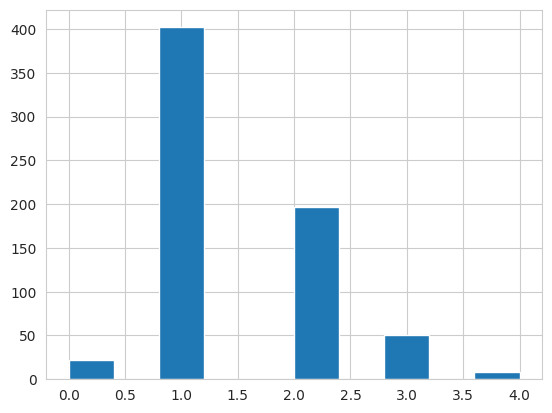

In [26]:
plt.hist(conformal_set_sizes)

In [27]:
np.argmax(y_test_np, axis=1)

array([205, 174,  73, 146, 171, 176, 205, 217,  75, 133,  93, 101, 208,
        76, 110,  67, 141, 205,  28, 152, 154, 152, 153, 119,  82,  73,
       155,  24, 140, 205,  30, 130,  92,  10, 120, 176,  68, 146, 146,
       205, 157, 138, 138,  59, 205,   5,   5,  56, 143, 146, 176, 205,
       104,  67, 128,   8, 204,  32,  82,  58,  67, 205, 133, 179, 146,
       185, 105, 205,  18, 136,  36,  18, 204, 149,  61,  90,  64, 205,
       195,  55,  76, 153, 136, 205,  39, 140,  41, 204, 190,  82, 214,
       196,  60, 113,  62,  27,   2, 205,  88, 205,   7, 137,  29,   3,
        67, 138, 205,  67,  89, 130, 112, 176,  54, 101, 199, 196,  43,
       107, 170, 205,  27, 134,  83,  61, 176, 153, 205, 130, 153,  41,
       205, 146, 148, 205, 205,  11, 146, 158, 121,  99,  86,  54,  23,
        85,  48,  79, 136, 202, 205, 205, 118,  92, 183,  27,  12, 141,
       200,  56, 176, 205, 182, 107,  56, 120, 176,  75, 175, 205, 205,
       146,  57, 148, 101, 125, 177,   7, 108, 154,  67, 205, 17

In [28]:
y_test_true[:10]

array([205, 174,  73, 146, 171, 176, 205, 217,  75, 133])

In [29]:
predictions_test

array([[4.1426262e-09, 3.5436123e-09, 1.1051833e-11, ..., 1.1122401e-11,
        1.8829551e-11, 3.3680996e-12],
       [1.5648568e-09, 1.3144143e-11, 3.7435841e-10, ..., 4.2698386e-10,
        4.1964254e-09, 3.8093681e-10],
       [3.3548266e-09, 1.7350410e-10, 1.1795048e-09, ..., 2.0451345e-10,
        1.8524293e-08, 1.9438022e-10],
       ...,
       [5.4121205e-09, 7.9545659e-09, 9.6192490e-12, ..., 6.6953279e-12,
        1.3650057e-11, 3.0081718e-12],
       [1.5927077e-09, 5.7479848e-09, 7.0487023e-12, ..., 5.5768229e-12,
        9.2621640e-12, 9.1245171e-12],
       [1.3007515e-08, 3.5309000e-10, 2.8793257e-10, ..., 2.6208807e-10,
        1.7380858e-09, 6.1343444e-11]], dtype=float32)

In [ ]:
np.save()

In [ ]:
y_val_np = our_results_val[0].cpu().numpy()
y_test_np = our_results_test[0].cpu().numpy()

In [ ]:
y_val_true = our_results_val[1].cpu().numpy()
y_test_true = our_results_test[1].cpu().numpy()

In [31]:
np.save('y_val_pred_proba.npy', y_val_np)
np.save('y_test_pred_proba.npy', y_test_np)
np.save('y_val_true.npy', y_val_true)
np.save('y_test_true.npy', y_test_true)
np.save('conformity_sets.npy', prediction_sets)